2023-01-14 22:47:33.948411: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-14 22:47:34.096013: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-14 22:47:34.096032: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-14 22:47:35.073307: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Train data:  (50000, 32, 32, 3)
Train filenames:  (50000,)
Train labels:  (50000, 10)
Test data:  (10000, 32, 32, 3)
Test filenames:  (10000,)
Test labels:  (10000, 10)
Label names:  (10,)


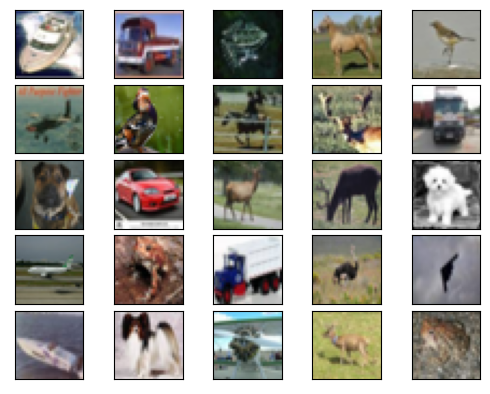

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 quantize_layer (QuantizeLayer)  (None, 32, 32, 3)   3           ['input_1[0][0]']                
                                                                                                  
 quant_conv2d (QuantizeWrapperV  (None, 32, 32, 16)  481         ['quantize_layer[0][0]']         
 2)                                                                                        

 quant_batch_normalization_6 (Q  (None, 8, 8, 64)    259         ['quant_conv2d_7[0][0]']         
 uantizeWrapperV2)                                                                                
                                                                                                  
 quant_add_2 (QuantizeWrapperV2  (None, 8, 8, 64)    1           ['quant_conv2d_8[0][0]',         
 )                                                                'quant_batch_normalization_6[0][
                                                                 0]']                             
                                                                                                  
 quant_activation_6 (QuantizeWr  (None, 8, 8, 64)    3           ['quant_add_2[0][0]']            
 apperV2)                                                                                         
                                                                                                  
 quant_ave

KeyboardInterrupt: 

In [1]:
'''
@ Brief : This source used to quantize model by aware-training
The original model is used also to convert to quantized model
'''

import tensorflow as tf
import tensorflow_model_optimization as tfmot
import numpy as np
import train
from test import model_name
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical
import datetime

#tfmodel_path = 'trained_models/' + model_name
tfmodel_path = 'trained_models/pretrainedResnet.h5'
tfmodel = tf.keras.models.load_model(tfmodel_path)

cifar_10_dir = 'cifar-10-batches-py'
model_name = model_name[:-3]

quantize_model = tfmot.quantization.keras.quantize_model

# train model 

EPOCHS = 500
BS = 32             # batch size = 32

# get date ant time to save model
dt = datetime.datetime.today()
year = dt.year
month = dt.month
day = dt.day
hour = dt.hour
minute = dt.minute

"""
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 
training images and 10000 test images.
The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains 
exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random 
order, but some training batches may contain more images from one class than another. Between them, the training 
batches contain exactly 5000 images from each class.
"""

#learning rate schedule
def lr_schedule(epoch):
    initial_learning_rate = 0.001
    decay_per_epoch = 0.99
    lrate = initial_learning_rate * (decay_per_epoch ** epoch)
    print('Learning rate = %f'%lrate)
    return lrate

lr_scheduler = LearningRateScheduler(lr_schedule)

#optimizer
optimizer = tf.keras.optimizers.Adam()

#define data generator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    #brightness_range=(0.9, 1.2),
    #contrast_range=(0.9, 1.2),
    validation_split=0.2
)

def unpickle(file):
    """load the cifar-10 data"""

    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data


def load_cifar_10_data(data_dir, negatives=False):
    """
    Return train_data, train_filenames, train_labels, test_data, test_filenames, test_labels
    """

    # get the meta_data_dict
    # num_cases_per_batch: 1000
    # label_names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    # num_vis: :3072

    meta_data_dict = unpickle(data_dir + "/batches.meta")
    cifar_label_names = meta_data_dict[b'label_names']
    cifar_label_names = np.array(cifar_label_names)

    # training data
    cifar_train_data = None
    cifar_train_filenames = []
    cifar_train_labels = []

    for i in range(1, 6):
        cifar_train_data_dict = unpickle(data_dir + "/data_batch_{}".format(i))
        if i == 1:
            cifar_train_data = cifar_train_data_dict[b'data']
        else:
            cifar_train_data = np.vstack((cifar_train_data, cifar_train_data_dict[b'data']))
        cifar_train_filenames += cifar_train_data_dict[b'filenames']
        cifar_train_labels += cifar_train_data_dict[b'labels']

    cifar_train_data = cifar_train_data.reshape((len(cifar_train_data), 3, 32, 32))
    if negatives:
        cifar_train_data = cifar_train_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        cifar_train_data = np.rollaxis(cifar_train_data, 1, 4)
    cifar_train_filenames = np.array(cifar_train_filenames)
    cifar_train_labels = np.array(cifar_train_labels)

    cifar_test_data_dict = unpickle(data_dir + "/test_batch")
    cifar_test_data = cifar_test_data_dict[b'data']
    cifar_test_filenames = cifar_test_data_dict[b'filenames']
    cifar_test_labels = cifar_test_data_dict[b'labels']

    cifar_test_data = cifar_test_data.reshape((len(cifar_test_data), 3, 32, 32))
    if negatives:
        cifar_test_data = cifar_test_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        cifar_test_data = np.rollaxis(cifar_test_data, 1, 4)
    cifar_test_filenames = np.array(cifar_test_filenames)
    cifar_test_labels = np.array(cifar_test_labels)

    return cifar_train_data, cifar_train_filenames, to_categorical(cifar_train_labels), \
        cifar_test_data, cifar_test_filenames, to_categorical(cifar_test_labels), cifar_label_names


if __name__ == "__main__":
    """load cifar10 data and trains model"""

    cifar_10_dir = 'cifar-10-batches-py'

    train_data, train_filenames, train_labels, test_data, test_filenames, test_labels, label_names = \
        load_cifar_10_data(cifar_10_dir)

    print("Train data: ", train_data.shape)
    print("Train filenames: ", train_filenames.shape)
    print("Train labels: ", train_labels.shape)
    print("Test data: ", test_data.shape)
    print("Test filenames: ", test_filenames.shape)
    print("Test labels: ", test_labels.shape)
    print("Label names: ", label_names.shape)

    # Don't forget that the label_names and filesnames are in binary and need conversion if used.

    # display some random training images in a 25x25 grid
    num_plot = 5
    f, ax = plt.subplots(num_plot, num_plot)
    for m in range(num_plot):
        for n in range(num_plot):
            idx = np.random.randint(0, train_data.shape[0])
            ax[m, n].imshow(train_data[idx])
            ax[m, n].get_xaxis().set_visible(False)
            ax[m, n].get_yaxis().set_visible(False)
    f.subplots_adjust(hspace=0.1)
    f.subplots_adjust(wspace=0)
    plt.show()

    #new_model = keras_model.resnet_v1_eembc()
    #new_model.summary()

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(train_data)

    #q_aware stands for quantization aware
    q_aware_model = quantize_model(tfmodel)
    # q_aware_model.compile(optimizer = 'adam',
    #         loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    #         metrics=['accuracy'])
    q_aware_model.compile(
        optimizer=optimizer, loss='categorical_crossentropy', metrics='accuracy', loss_weights=None,
        weighted_metrics=None, run_eagerly=None )
    q_aware_model.summary()

    # fits the model on batches with real-time data augmentation:
    History = q_aware_model.fit(datagen.flow(train_data, train_labels, batch_size=BS),
              steps_per_epoch=len(train_data) / BS, epochs=EPOCHS, callbacks=[lr_scheduler])

    plt.plot(np.array(range(EPOCHS)), History.history['loss'])
    plt.plot(np.array(range(EPOCHS)), History.history['accuracy'])
    plt.savefig('train_loss_acc.png')
    model_name = "trainedResnet_quantAware.h5"
    q_aware_model.save("trained_models/" + model_name)
